In [ ]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from hyperopt import fmin, tpe, hp, Trials
import xgboost as xgb
from google.colab import drive
from typing import Tuple
import pickle
import matplotlib.pyplot as plt
from scipy.stats import kstest
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/drive/MyDrive/Documents/MAESTRIA/2023-1/Econometria/ECV_AguaConsumo_Final_KP2_Actualizada.csv', 'r') as f:
    df = pd.read_csv(f, delimiter=';')

In [ ]:
with open('/content/drive/MyDrive/Documents/MAESTRIA/2023-1/Econometria/Agua consumo.csv', 'r') as f:
    agua = pd.read_csv(f, delimiter=';')

In [ ]:
pred_im = np.loadtxt('/content/drive/MyDrive/Documents/MAESTRIA/2023-1/Econometria/preds.txt')

In [ ]:
warnings.filterwarnings("ignore")

In [ ]:
np.random.seed(42)
nume=["p8520s4a1","p6211","p5010","p5018","p5018s1","p3163","p3163s1","p5024","p5034","p5034s1","p5044s1","p5067","p5067s1","cant_personas_hogar","i_hogar","Agua_CargoFijo","Agua_CargoBasico","Agua_ConsumoComplementario","Agua_ConsumoSuntuoso","Kinkpoint_basico","PagoMes","Kinkpoint_2"]



cat=['p3155',	'p1070',	'Estrato',	'p8587',	'p5047',	'Divipola']


vars_to_keep = nume + cat
df = df[vars_to_keep]

In [ ]:
for n in nume:
    df[n]=pd.to_numeric(df[n], errors='coerce')

In [ ]:
for c in cat:
  df[c] = df[c].astype('category')

In [ ]:
def price_function(df):

  Gasto_Agua=df['PagoMes'].values.squeeze()
  Fijo = df['Agua_CargoFijo'].values.squeeze()
  Gasto_basico = df['Agua_CargoBasico'].values.squeeze()
  Consumo_max_Basicos = df['Kinkpoint_basico'].values.squeeze()
  Gasto_Complementario = df['Agua_ConsumoComplementario'].values.squeeze()
  Consumo_max_complementario = df['Kinkpoint_2'].values.squeeze()
  Gasto_suntuario=df['Agua_ConsumoSuntuoso'].values.squeeze()



  Con= np.zeros_like(Gasto_Agua)


  for i in range(len(Gasto_Agua)):

    if Gasto_Agua[i]-Fijo[i]-Gasto_basico[i]*Consumo_max_Basicos[i]<0:
      Consumo=(Gasto_Agua[i]-Fijo[i])/Gasto_basico[i]
    elif Gasto_Agua[i]-Fijo[i]-Gasto_basico[i]*Consumo_max_Basicos[i]- Gasto_Complementario[i]*Consumo_max_complementario[i]<0:
      Consumo= (Gasto_Agua[i]-Fijo[i]-Gasto_basico[i]*Consumo_max_Basicos[i])/Gasto_Complementario[i] + Consumo_max_Basicos[i]
    else:
      Consumo= (Gasto_Agua[i]-Fijo[i]-Gasto_basico[i]*Consumo_max_Basicos[i]- Gasto_Complementario[i]*(Consumo_max_complementario[i]-Consumo_max_Basicos[i]))/Gasto_suntuario[i] + Consumo_max_Basicos[i] + Consumo_max_complementario[i]
    Con[i]=Consumo

  return Con


In [ ]:
def custom_loss_space(params):
    bst = xgb.train(params, dtrain)
    predt = bst.predict(dtest)
    y_true = y_test.values.squeeze()
    Agua_CargoFijo = X_test['Agua_CargoFijo'].values.squeeze()
    Agua_CargoBasico = X_test['Agua_CargoBasico'].values.squeeze()
    Kinkpoint_basico = X_test['Kinkpoint_basico'].values.squeeze()
    Agua_ConsumoComplementario = X_test['Agua_ConsumoComplementario'].values.squeeze()
    Kinkpoint_2 = X_test['Kinkpoint_2'].values.squeeze()
    Agua_ConsumoSuntuoso=X_test['Agua_ConsumoSuntuoso'].values.squeeze()
    
    loss = np.zeros_like(y_true)

    for i in range(len(y_true)):
        if predt[i]<Kinkpoint_basico[i]:
            Exp_Agra = (predt[i]*Agua_CargoBasico[i]+Agua_CargoFijo[i])
        elif predt[i]<Kinkpoint_2[i]:
             Exp_Agra = ((predt[i]-Kinkpoint_basico[i])*Agua_ConsumoComplementario[i]+Kinkpoint_basico[i]*Agua_CargoBasico[i]+Agua_CargoFijo[i])
        else:
             Exp_Agra = ((predt[i]-Kinkpoint_basico[i]-Kinkpoint_2[i])*Agua_ConsumoSuntuoso[i]+Kinkpoint_basico[i]*Agua_CargoBasico[i]+(Kinkpoint_2[i]-Kinkpoint_basico[i])*Agua_ConsumoComplementario[i]+Agua_CargoFijo[i])
        loss[i] = (Exp_Agra - y_true[i])**2
    
    return np.sqrt(np.mean(loss))


In [ ]:
def custom_loss(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[np.ndarray, np.ndarray]:
    y_true = dtrain.get_label()
    Agua_CargoFijo = X_train['Agua_CargoFijo'].values.squeeze()
    Agua_CargoBasico = X_train['Agua_CargoBasico'].values.squeeze()
    Kinkpoint_basico = X_train['Kinkpoint_basico'].values.squeeze()
    Agua_ConsumoComplementario = X_train['Agua_ConsumoComplementario'].values.squeeze()
    Kinkpoint_2 = X_train['Kinkpoint_2'].values.squeeze()
    Agua_ConsumoSuntuoso=X_train['Agua_ConsumoSuntuoso'].values.squeeze()
    
    grad = np.zeros_like(y_true)
    hess = np.zeros_like(y_true)
    
    for i in range(len(y_true)):
        if predt[i]<Kinkpoint_basico[i]:
            Exp_Agra = (predt[i]*Agua_CargoBasico[i]+Agua_CargoFijo[i])
            grad[i] = Agua_CargoBasico[i]*2*(Exp_Agra - y_true[i])
            hess[i] = 2*(Agua_CargoBasico[i])
        elif predt[i]<Kinkpoint_2[i]:
            Exp_Agra = ((predt[i]-Kinkpoint_basico[i])*Agua_ConsumoComplementario[i]+Kinkpoint_basico[i]*Agua_CargoBasico[i]+Agua_CargoFijo[i])
            grad[i] = Agua_ConsumoComplementario[i]*2*(Exp_Agra - y_true[i])
            hess[i] = 2*(Agua_ConsumoComplementario[i])
        else:
            Exp_Agra = ((predt[i]-Kinkpoint_basico[i]-Kinkpoint_2[i])*Agua_ConsumoSuntuoso[i]+Kinkpoint_basico[i]*Agua_CargoBasico[i]+(Kinkpoint_2[i]-Kinkpoint_basico[i])*Agua_ConsumoComplementario[i]+Agua_CargoFijo[i])
            grad[i] = Agua_ConsumoSuntuoso[i]*2*(Exp_Agra - y_true[i])
            hess[i] = 2*(Agua_ConsumoSuntuoso[i])
             
    return grad, hess

In [ ]:
def my_mse(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
    ''' mean squared error metric.'''
    y_true = dtrain.get_label()
    Agua_CargoFijo = X_train['Agua_CargoFijo'].values.squeeze()
    Agua_CargoBasico = X_train['Agua_CargoBasico'].values.squeeze()
    Kinkpoint_basico = X_train['Kinkpoint_basico'].values.squeeze()
    Agua_ConsumoComplementario = X_train['Agua_ConsumoComplementario'].values.squeeze()
    Kinkpoint_2 = X_train['Kinkpoint_2'].values.squeeze()
    Agua_ConsumoSuntuoso=X_train['Agua_ConsumoSuntuoso'].values.squeeze()

    loss = np.zeros_like(y_true)

    for i in range(len(y_true)):
        if predt[i]<Kinkpoint_basico[i]:
            Exp_Agra = (predt[i]*Agua_CargoBasico[i]+Agua_CargoFijo[i])
        elif predt[i]<Kinkpoint_2[i]:
             Exp_Agra = ((predt[i]-Kinkpoint_basico[i])*Agua_ConsumoComplementario[i]+Kinkpoint_basico[i]*Agua_CargoBasico[i]+Agua_CargoFijo[i])
        else:
             Exp_Agra = ((predt[i]-Kinkpoint_basico[i]-Kinkpoint_2[i])*Agua_ConsumoSuntuoso[i]+Kinkpoint_basico[i]*Agua_CargoBasico[i]+(Kinkpoint_2[i]-Kinkpoint_basico[i])*Agua_ConsumoComplementario[i]+Agua_CargoFijo[i])
        loss[i] = (Exp_Agra - y_true[i])**2
    return 'PyMSE', float(np.sqrt(np.sum(loss[i]) / len(y_true)))

In [ ]:
def get_moments(array):
    # Calculate the first four moments of the array
    mean = np.mean(array)
    variance = np.var(array)
    skewness = np.mean((array - mean)**3) / np.power(variance, 3/2)
    kurtosis = np.mean((array - mean)**4) / np.power(variance, 2) - 3

    # Return a dictionary with the moments
    moments = {'Mean': mean, 'Variance': variance, 'Skewness': skewness, 'Kurtosis': kurtosis}
    return moments


In [ ]:
def outliers(result, sd):
  z_scores = np.abs((result - result.mean()) / result.std())
  no_outliers = result[(z_scores < sd)]

  return no_outliers

In [ ]:
def Graph_St(var):
  sns.histplot(var, kde=True)

  # Get the moments of the data
  moments = get_moments(var)

  # Add text to the plot with moments
  plt.text(0.95, 0.95, f"Mean: {moments['Mean']:.2f}\nVariance: {moments['Variance']:.2f}\nSkewness: {moments['Skewness']:.2f}\nKurtosis: {moments['Kurtosis']:.2f}", fontsize=12, ha='right', va='top', transform=plt.gca().transAxes)

In [ ]:
def integral_est_mc(row):

    repeated_rows = pd.concat([row] * 1000, axis=1).transpose()
    precios=['Agua_CargoBasico','Agua_ConsumoComplementario','Agua_ConsumoSuntuoso']

    inter=[]

    for p in precios:
        a, b =row[p], row[p]*1.2
        samples = np.random.uniform(a, b, 1000)
        repeated_rows[p]=samples
        inter.append(b-a)

    X_r, y_r = repeated_rows.drop('PagoMes', axis=1), repeated_rows[['PagoMes']]

    dr_reg = xgb.DMatrix(X_r, y_r, enable_categorical=True)

    p_rep = model.predict(dr_reg)

    # generate random samples

    # calculate the integral estimate
    integral_estimate = (np.prod(inter) / (1000**2)) * np.sum(p_rep)

    return -integral_estimate

In [ ]:
X, y = df.drop('PagoMes', axis=1), df['PagoMes']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
# Create regression matrices
dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [ ]:
evals = [(dtrain, "train"), (dtest, "test")]

In [ ]:
space = {
    'learning_rate': hp.loguniform('learning_rate', -40, 0),
    'max_depth': hp.choice('max_depth', list(range(3,400))),
    'gamma': hp.loguniform('gamma', -85, 80),
    'min_child_weight': hp.quniform('min_child_weight', 1, 100, 1),
    'subsample': hp.uniform('subsample', 0.1, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1),
    'alpha': hp.choice('alpha', [0, hp.loguniform('alpha_positive', -60, 60)]),
    'lambda': hp.choice('lambda', [0, hp.loguniform('lambda_positive', -60, 60)]),
    'tree_method': 'gpu_hist',  # if you are using a GPU for training
}


# First phase hyperparameter search
trials = Trials()
best = fmin(custom_loss_space, space, algo=tpe.suggest, max_evals=100, trials=trials)

100%|██████████| 100/100 [00:15<00:00,  6.47trial/s, best loss: 23764.600397743354]


In [ ]:
best

{'alpha': 0,
 'colsample_bytree': 0.5795829584979774,
 'gamma': 144587.61540979304,
 'lambda': 0,
 'learning_rate': 3.230157522649244e-05,
 'max_depth': 80,
 'min_child_weight': 70.0,
 'subsample': 0.9294338156645701}

In [ ]:
best_params = {
    'tree_method': 'gpu_hist',
    'learning_rate': best['learning_rate'],
    'max_depth': int(best['max_depth']),
    'gamma': best['gamma'],
    'min_child_weight': int(best['min_child_weight']),
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'alpha': best['alpha'],
    'lambda': best['lambda']
}

In [ ]:
n = 10000
model = xgb.train(
   params=best_params,
   dtrain=dtrain,
   num_boost_round=n,
   obj=custom_loss,
   feval=my_mse,
   evals=evals,
   verbose_eval=100,
   # Activate early stopping
   early_stopping_rounds=20,
   
)

[0]	train-rmse:47568.37549	train-PyMSE:489.56134	test-rmse:46372.14328	test-PyMSE:544.54822
[100]	train-rmse:47542.59574	train-PyMSE:38.74528	test-rmse:46348.12021	test-PyMSE:199.74639
[200]	train-rmse:47541.10782	train-PyMSE:22.51354	test-rmse:46346.85450	test-PyMSE:195.88275
[228]	train-rmse:47540.97489	train-PyMSE:18.84357	test-rmse:46346.74575	test-PyMSE:196.31826


In [ ]:
preds = model.predict(dtest)

In [ ]:
preds.max()

240.83154

In [ ]:
preds.min()

-16.25975

In [ ]:
file_name = "/content/drive/MyDrive/Documents/MAESTRIA/2023-1/Econometria/modelf.pickle"

# Save the model
pickle.dump(model, open(file_name, "wb"))

In [ ]:
file_name = "/content/drive/MyDrive/Documents/MAESTRIA/2023-1/Econometria/modelf.pickle"
# load
model_loaded = pickle.load(open(file_name, "rb"))

In [ ]:
model=model_loaded 

In [ ]:
Y=model_loaded.predict(dtest) == model.predict(dtest)


In [ ]:
Y=Y.squeeze()

In [ ]:
test_load= [0 if i==True  else 1 for i in Y]

In [ ]:
sum(test_load)

0

In [ ]:
X_t, y_t=df.drop('PagoMes', axis=1), df[['PagoMes']]

tot_reg = xgb.DMatrix(X_t, y_t, enable_categorical=True)

In [ ]:
preds_df= model.predict(tot_reg )

In [ ]:
preds_df = pd.DataFrame(preds_df, columns=['predictions'])


preds_df.to_csv('/content/drive/MyDrive/Documents/MAESTRIA/2023-1/Econometria/preds.txt', index=False)

$$
Int_i=\int_{c_{Basic_{i}}*1.2}^{c_{Basic_{i}}}\int_{c_{Comple_{i}}*1.2}^{c_{Comple_{i}}}\int_{c_{Sump_{i}}*1.2}^{c_{Sump_{i}}} \hat{Y_i} \ dc_{Basic_{i}}\ dc_{Comple_{i}}\ dc_{Sump_{i}}
$$


In [ ]:
result_ddf =df.apply(integral_est_mc, axis=1)

In [ ]:
result_ddf.to_csv('/content/drive/MyDrive/Documents/MAESTRIA/2023-1/Econometria/resultf.txt', index=False)

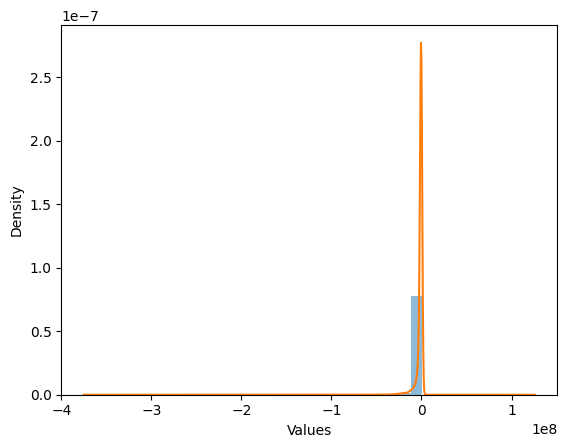

In [ ]:
# Assuming your result_ddf series is a pandas dataframe
result_ddf.plot(kind='hist', density=True, alpha=0.5, bins=20)

# Adding a predicted density curve
result_ddf.plot(kind='density')

plt.xlabel('Values')
plt.ylabel('Density')
plt.show()

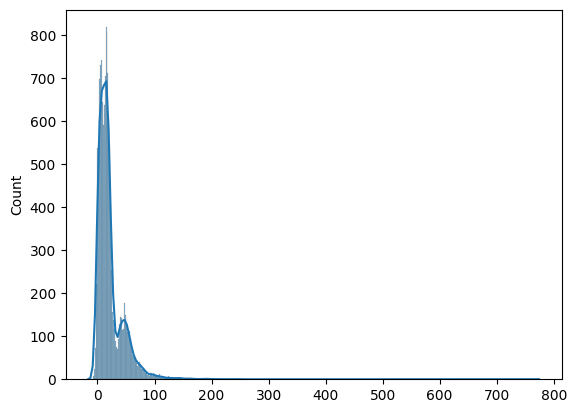

In [ ]:
preds_t = model.predict(tot_reg)

import seaborn as sns

# Assuming your result_ddf is a pandas Series
sns.histplot(preds_t, kde=True)
plt.show()

In [ ]:
df["Consumo"].max()

798.4161073825503

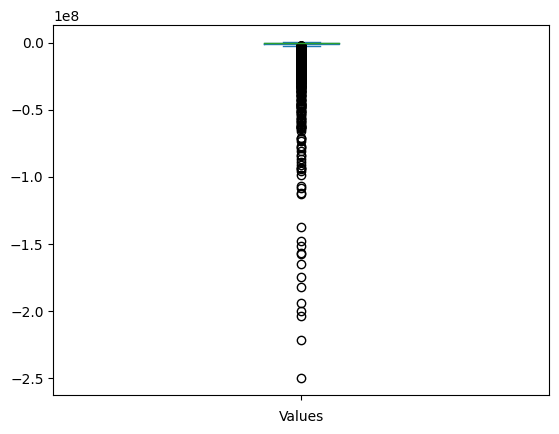

In [ ]:
result_ddf.plot(kind='box')

plt.xlabel('Values')
plt.show()

In [ ]:
z_scores = np.abs((result_ddf - result_ddf.mean()) / result_ddf.std())
result_ddf_no_outliers = result_ddf[(z_scores < .5)]

In [ ]:
len(z_scores)

15336

In [ ]:
len(result_ddf_no_outliers )

14293

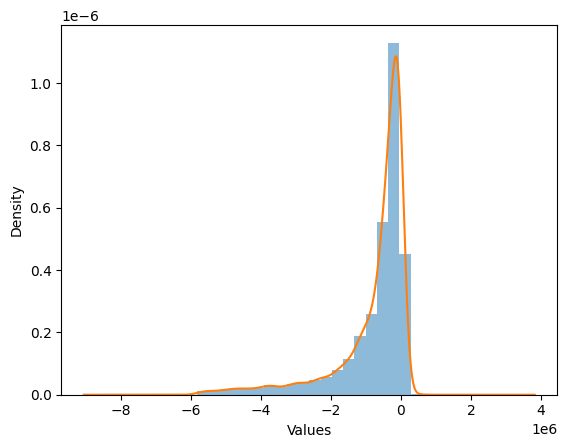

In [ ]:
import matplotlib.pyplot as plt

# Assuming your result_ddf series is a pandas dataframe
result_ddf_no_outliers.plot(kind='hist', density=True, alpha=0.5, bins=20)

# Adding a predicted density curve
result_ddf_no_outliers.plot(kind='density')

plt.xlabel('Values')
plt.ylabel('Density')
plt.show()

In [ ]:
np.median(result_ddf_no_outliers)

-353227.11054274824

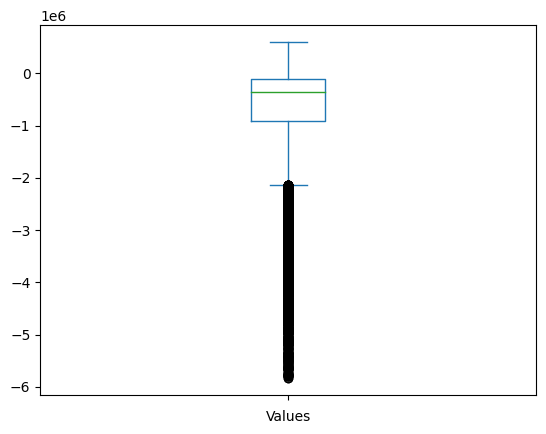

In [ ]:
result_ddf_no_outliers.plot(kind='box')

plt.xlabel('Values')
plt.show()

In [ ]:
max_count = np.max(np.histogram(result_ddf_no_outliers, bins=100)[0])  # Find the maximum value of the histogram

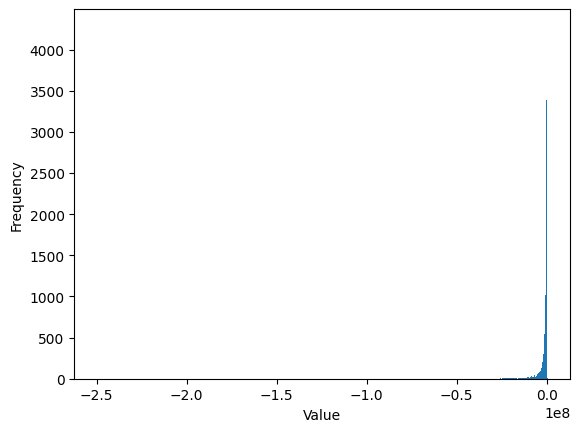

x value corresponding to the highest point of the distribution:  -25462.6279437989
x value for the median of the distribution:  -398744.3556124213


In [ ]:

# Assuming your data is in a NumPy array called `data`
n, bins, patches = plt.hist(result_ddf, bins=1000)  # Plot a histogram with 20 bins
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

bin_idx = np.argmax(n)  # Find the index of the bin with the highest frequency count
mode_x = (bins[bin_idx] + bins[bin_idx+1])/2  # Compute the midpoint of the bin

print("x value corresponding to the highest point of the distribution: ", mode_x)
print("x value for the median of the distribution: ", np.median(result_ddf))



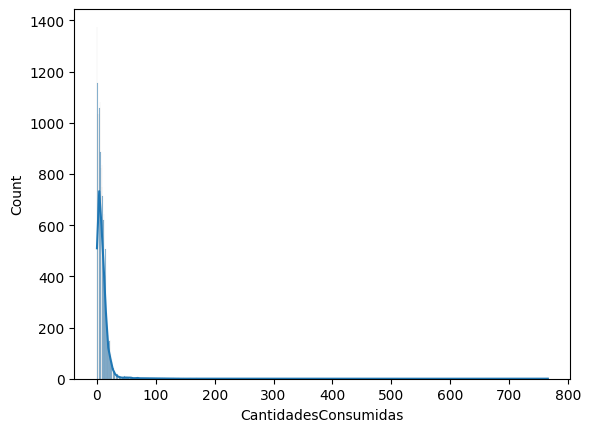

In [ ]:
# Assuming your result_ddf is a pandas Series
sns.histplot(agua["CantidadesConsumidas"], kde=True)
plt.show()

In [ ]:
z_scores_agua = np.abs(agua["CantidadesConsumidas"]- agua["CantidadesConsumidas"].mean()) / agua["CantidadesConsumidas"].std()
agua_no_outliers = agua["CantidadesConsumidas"][(z_scores_agua < 3)]

In [ ]:
Consumo=price_function(df)

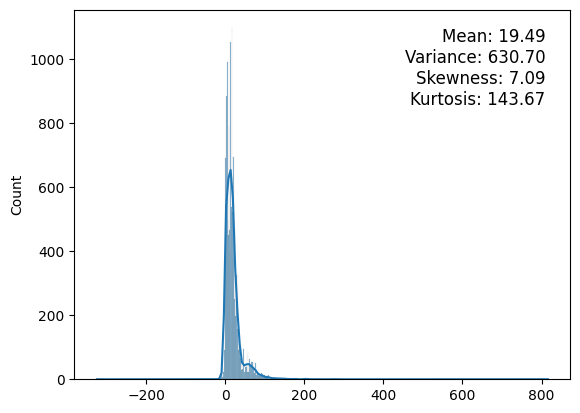

In [ ]:
Graph_St(Consumo)
plt.show()

In [ ]:
Consumo


23.961340206185568

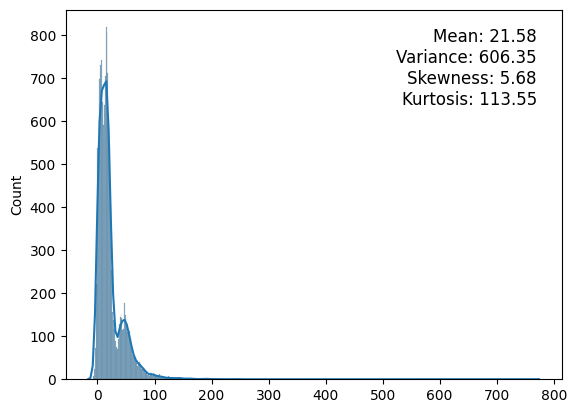

In [ ]:
Graph_St(preds_df)
# Display the plot
plt.show()

In [ ]:
# Perform the Kolmogorov-Smirnov test
statistic, pvalue = kstest(preds_df, Consumo)

# Print the results
print(f"Kolmogorov-Smirnov statistic: {statistic:.4f}")
print(f"P-value: {pvalue:.4f}")

Kolmogorov-Smirnov statistic: 0.0820
P-value: 0.0000
